In [15]:
from pyciemss import PetriNetODE

In [16]:
import os

from pyciemss.PetriNetODE.interfaces import load_petri_model, setup_model, sample, calibrate
import pyciemss
import numpy as np

Let's see what directory we're in

In [17]:
os.getcwd()

'/home/chads/git/askem/pyciemss/notebook'

Most of our files are relative to `test/models/`, so we need to go up a directory.

In [18]:
PYCIEMSS_PATH = ".."
STARTERKIT_PATH = os.path.join(PYCIEMSS_PATH, "test/models/starter_kit_examples/")
MIRA_PATH = os.path.join(PYCIEMSS_PATH, "test/models/evaluation_examples/")

filename = "CHIME-SIR/model_petri.json"
filename = os.path.join(STARTERKIT_PATH, filename)

model = load_petri_model(filename, add_uncertainty=True)
model = setup_model(model, start_time=0.0, start_state=dict(S=0.99, I=0.01, R=0.0))

In [19]:
model

ScaledBetaNoisePetriNetODESystem((a_beta=Uniform(low: 0.8999999761581421, high: 1.100000023841858)), (a_gamma=Uniform(low: 0.8999999761581421, high: 1.100000023841858)), pseudocount=1)

In [20]:
import matplotlib.pyplot as plt

def plot_sample(times, s, names, alpha=1, **kwargs):
    for i,name in enumerate(names):
        for trajectory in s[name]:
            plt.plot(times, trajectory, label=name, alpha=alpha, color='C' + str(i), **kwargs)

In [21]:
import torch
model.pseudocount = torch.tensor(1000.0)

Text(0, 0.5, 'a_gamma')

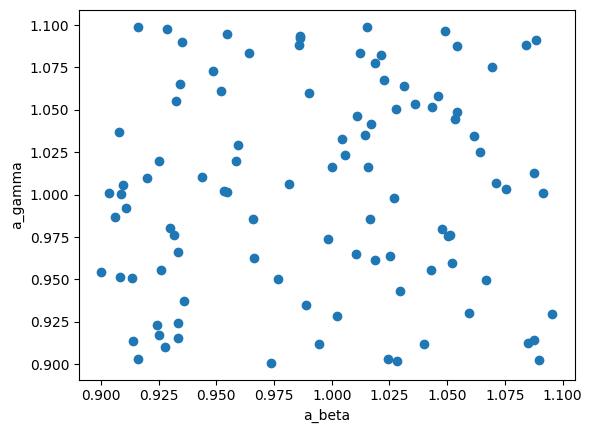

In [22]:
import random
import pyro
pyro.set_rng_seed(3)
random.seed(0)
times = np.linspace(0.01, 30, 100)
num_samples = 100
data = sample(model, times, num_samples)
plt.scatter(data["a_beta"], data["a_gamma"])
plt.xlabel("a_beta")
plt.ylabel("a_gamma")

In [23]:
observed_indices = np.sort(np.random.choice(range(0,100), 10, replace=False))
observed_indices

array([ 6, 15, 25, 42, 64, 67, 83, 93, 96, 98])

In [24]:
import pyro
mu = data['I_sol'][0][observed_indices]
obs_times = times[observed_indices]
obs_vals = pyro.distributions.Beta(mu * model.pseudocount, (1 - mu) * model.pseudocount).sample()

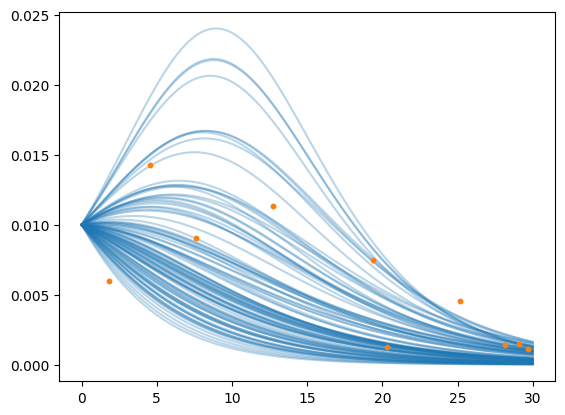

In [25]:
plot_sample(times, data, ('I_sol',), alpha=0.3, zorder=1)
plt.scatter(obs_times, obs_vals, color='C1', zorder=2, s=10)

In [26]:
obs = [(times[j], 
        {var: float(data[var + "_sol"][0,j]) for var in ["S", "I", "R"]})
    for j in observed_indices]

In [27]:
len(obs)

10

In [28]:
post = calibrate(model, obs, verbose=True, num_iterations=300)
post

tensor([0.9712, 0.9430, 0.9138, 0.8745, 0.8444, 0.8418, 0.8317, 0.8279, 0.8271,
        0.8266])
<built-in function max>


TypeError: unsupported operand type(s) for /: 'Tensor' and 'builtin_function_or_method'

In [ ]:
post_sample = sample(model, np.linspace(0.01, 30, 100), 100, inferred_parameters=post)

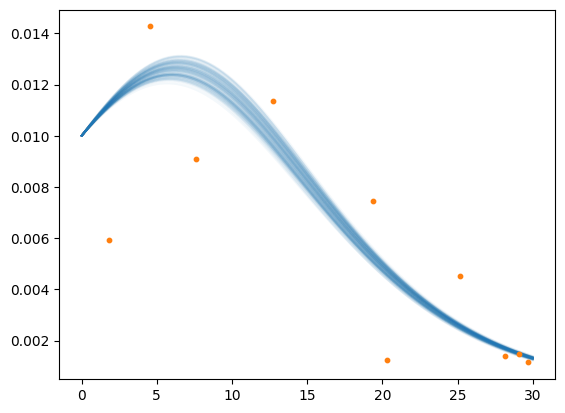

In [ ]:
plot_sample(times, post_sample, ('I_sol',), alpha=0.05, zorder=1)
plt.scatter(times[observed_indices], obs_vals, color='C1', zorder=2, s=10)

Text(0, 0.5, 'a_gamma')

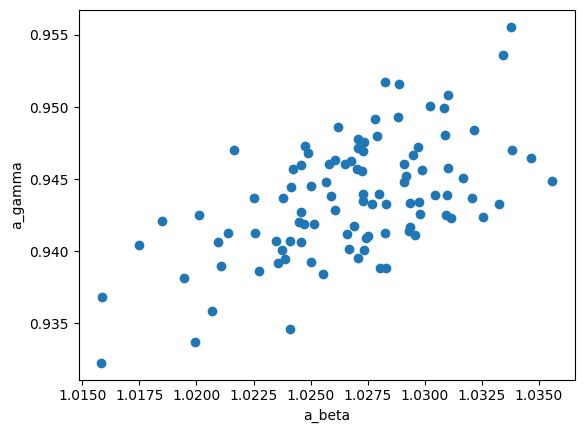

In [ ]:
plt.scatter(post_sample["a_beta"], post_sample["a_gamma"])
plt.xlabel("a_beta")
plt.ylabel("a_gamma")